<a href="https://colab.research.google.com/github/fabiano182/AMC/blob/main/AMC_MIMO_Canal_Real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import h5py
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt


hf = h5py.File('/content/drive/MyDrive/TCC_COLAB/Datasets/UMa_6GHz_BS_ULA_16_UE_ULA_16.h5','r')

In [ ]:
hfd = list([])
for i,ds in enumerate(hf.keys()):
  hfd.append(hf[ds][:,:])
hd = np.array(hfd)


In [ ]:
print(hd.dtype)
print(hd.shape)

[('real', '<f8'), ('imag', '<f8')]
(50000, 16, 16)


In [ ]:
def awgn(snr, nRx, L):
  EbNo = snr
  var = np.sqrt(1/(10**(EbNo/10))) 
  w = (np.random.normal(0,var,(1,nRx,L)) + 1j*np.random.normal(0,var,(1,nRx,L)))
  return w

In [ ]:
!pip install ModulationPy==0.1.8 

In [ ]:
from ModulationPy import PSKModem, QAMModem

def psk_mod(M, L):
  modem = PSKModem(M, gray_map=True, bin_input=False)
  if M==4: modem = PSKModem(M, phi=np.pi/4, gray_map=True, bin_input=False)
  input = np.random.randint(low=0, high=M, size=L)
  x = modem.modulate(input)
  return x

def qam_mod(M, L):
  modem = QAMModem(M, gray_map=True, bin_input=False)
  input = np.random.randint(low=0, high=M, size=L)
  x = modem.modulate(input)
  return x

# Normalização da constelação

In [ ]:
def rayChan(nTx,nRx):
  H = np.array(hd[np.random.randint(0,hd.shape[0]),:nRx,:nTx].tolist()).astype(float) # Escolhe uma amostra aleatória do canal entre as 50k
  
  # if (nTx == 2 and nRx == 1):
  #   Hl = np.array([H[0][0][0] + 1j*H[0][0][1], H[1][0][0] + 1j*H[1][0][1]])

  # if (nTx == 2 and nRx == 2):
  #   Hl = np.array([[H[0][0][0] + 1j*H[0][0][1], H[1][0][0] + 1j*H[1][0][1]],
  #                 [ H[0][1][0] + 1j*H[0][1][1], H[1][1][0] + 1j*H[1][1][1]]])

  # h_chann = []
  # for t in range(nTx):
  #  htr = []
  #  for r in range(nRx):
  #    htr = np.append(htr,[H[t][r][0] + 1j*H[t][r][1]])

  #  h_chann.append(htr)

  H = np.array(H[:,:,0] + 1j*H[:,:,1])

  ''' channel normalization '''
  HF = np.linalg.norm(H, 'fro') # Frobenius norm
  Hn = np.sqrt(nRx)/HF * H

  return Hn
  # return np.ones([nTx,nRx])

h = rayChan(4, 4)
print(h)

[[ 0.263-0.419j -0.112-0.238j -0.028-0.402j  0.131-0.564j]
 [ 0.139-0.774j -0.021-0.249j  0.094-0.247j  0.158-0.563j]
 [-0.112-0.827j  0.037-0.367j  0.28 -0.245j  0.193-0.398j]
 [-0.179-0.597j -0.039-0.434j  0.291-0.352j  0.317-0.201j]]


In [ ]:
def mimo(x, nRx, nTx, snr):
  x = np.tile(x,(nTx,1))
  H = rayChan(nRx,nTx)
  #H = np.ones([nRx,nTx])
  w = awgn(snr, nRx, 128)
  
  # print('x: ',x.shape)
  # print('H: ',H.shape)

  y = np.sum((np.dot(H.T,x))/np.sqrt(nTx) + w, axis=1)
 
  return np.reshape(np.array([[y.real],[y.imag]]),[1,2,128])



(1, 2, 128)


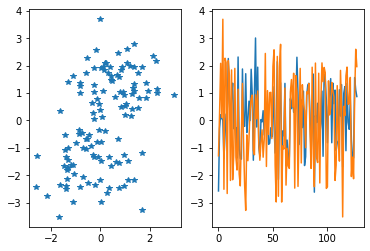

In [ ]:
s = mimo(psk_mod(2,128), 4, 1 ,5)

print(s.shape)

sI = s[0,0,:]; sQ = s[0,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

[ 0. 20.]


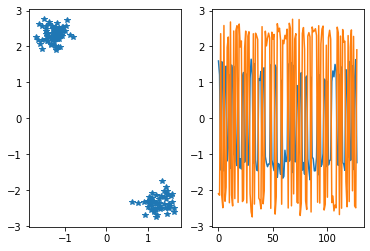

[ 1. 20.]


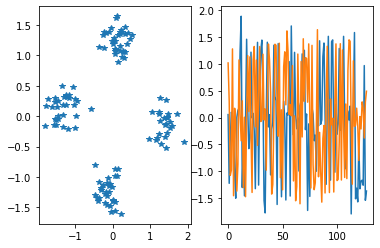

[ 2. 20.]


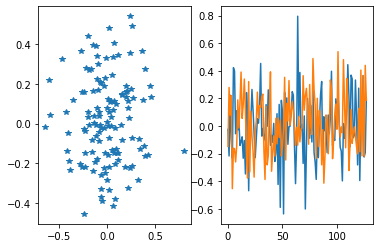

[ 3. 20.]


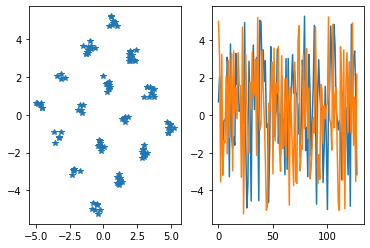

[ 4. 20.]


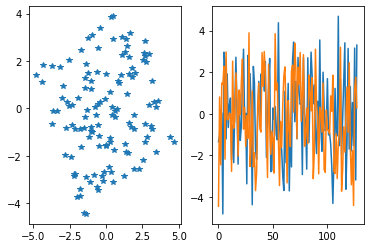

In [ ]:
nTx = 4; nRx = 4 ; L = 128
snrs = list(range(-20,25,5))
ntest = 2500
t = ntest*len(snrs)
data_bpsk = np.zeros([t,2,L])
data_qpsk = np.zeros([t,2,L])
data_16qam = np.zeros([t,2,L])
data_8psk = np.zeros([t,2,L])
data_64qam = np.zeros([t,2,L])

lbl_bpsk = np.zeros([t,2])
lbl_qpsk = np.zeros([t,2])
lbl_8psk = np.zeros([t,2])
lbl_16qam = np.zeros([t,2])
lbl_64qam = np.zeros([t,2])

for i,snr in enumerate(snrs):
  for j in range(ntest):
    data_bpsk[i*ntest+j,:,:] = mimo(psk_mod(2,L), nRx, nTx ,snr)
    lbl_bpsk[i*ntest+j,:] = [0, snr]
  
  for j in range(ntest):
    data_qpsk[i*ntest+j,:,:] = mimo((1/np.sqrt(2))*psk_mod(4,L), nRx, nTx ,snr)
    lbl_qpsk[i*ntest+j,:] = [1, snr]

  for j in range(ntest):
    data_8psk[i*ntest+j,:,:] = mimo((1/np.sqrt(2))*psk_mod(8,L), nRx, nTx ,snr)
    lbl_8psk[i*ntest+j,:] = [2, snr]
  
  for j in range(ntest):
    data_16qam[i*ntest+j,:,:] = mimo((1/np.sqrt(10))*qam_mod(16,L), nRx, nTx ,snr)
    lbl_16qam[i*ntest+j,:] = [3, snr]
  
  for j in range(ntest):
    data_64qam[i*ntest+j,:,:] = mimo((1/np.sqrt(42))*qam_mod(64,L), nRx, nTx ,snr)
    lbl_64qam[i*ntest+j,:] = [4, snr]

print(lbl_bpsk[-1,:])
sI = data_bpsk[-1,0,:]; sQ = data_bpsk[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

print(lbl_qpsk[-1,:])
sI = data_qpsk[-1,0,:]; sQ = data_qpsk[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

print(lbl_8psk[-1,:])
sI = data_8psk[-1,0,:]; sQ = data_8psk[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

print(lbl_16qam[-1,:])
sI = data_16qam[-1,0,:]; sQ = data_16qam[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

print(lbl_64qam[-1,:])
sI = data_64qam[-1,0,:]; sQ = data_64qam[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

In [ ]:
data = np.vstack((data_bpsk, data_qpsk, data_8psk, data_16qam, data_64qam))
label = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,0].astype(int)
snrs = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,1].astype(int)
print(data.shape)
print(label.shape)
print(snrs.shape)

(112500, 2, 128)
(112500,)
(112500,)


In [ ]:
def one_hot_encode(x, n_classes):
  return np.eye(n_classes)[x]

n_classes = 5
lbl_onehot = one_hot_encode(label.T, n_classes)

Xt = data
Yt = lbl_onehot

print(Xt.shape)
print(Yt.shape)

(112500, 2, 128)
(112500, 5)


In [ ]:
idx = list(range(lbl_onehot.shape[0]))
np.random.shuffle(idx)

data = data[idx,:,:]
lbl_onehot = lbl_onehot[idx,:]
snrs = snrs[idx]

split = 0.75 #70% Treino 30% Validação
total = data.shape[0] #30k amostras
sp = int(split*total)

X_test = data[:sp,:,:]
Y_test = lbl_onehot[0:sp,:]

X_val = data[-(total-sp):,:,:]
Y_val = lbl_onehot[-(total-sp):,:]

print(X_test.shape, X_val.shape)
print(Y_test.shape,Y_val.shape)
#print(snrs.shape)

(84375, 2, 128) (28125, 2, 128)
(84375, 5) (28125, 5)


In [ ]:
import keras
from keras.layers import *
from keras.models import Model
from keras.activations import *
from keras.callbacks import ModelCheckpoint, EarlyStopping

def cnn2():
  dr = 0.25

  input = Input((2, 128, 1))
  x = ZeroPadding2D((0,2))(input)                               
  x = Conv2D(256, (2, 3))(x)
  x = ReLU()(x)                                   
  x = Dropout(dr)(x)

  x = ZeroPadding2D((0,2))(x) 
  x = Conv2D(64, (1, 3))(x)   
  x = ReLU()(x)
  x = Dropout(dr)(x)

  x = Flatten()(x)
  x = Dense(128)(x)
  x = ReLU()(x)
  x = Dropout(dr)(x)


  output = Dense(n_classes, activation='softmax')(x)      #Camada de saida
  model = Model(inputs=input, outputs=output)
  #model.summary()
  return model

In [ ]:
%%time
model = cnn2()
opt = tf.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

history = model.fit(X_test,Y_test,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_val,Y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', verbose=1, patience=10)])

Epoch 1/100
660/660 [==============================] - 13s 18ms/step - loss: 1.6110 - categorical_accuracy: 0.2194 - val_loss: 1.5492 - val_categorical_accuracy: 0.2834
Epoch 2/100
660/660 [==============================] - 12s 18ms/step - loss: 1.4491 - categorical_accuracy: 0.3072 - val_loss: 1.3998 - val_categorical_accuracy: 0.3316
Epoch 3/100
660/660 [==============================] - 11s 17ms/step - loss: 1.3683 - categorical_accuracy: 0.3435 - val_loss: 1.3141 - val_categorical_accuracy: 0.3615
Epoch 4/100
660/660 [==============================] - 11s 17ms/step - loss: 1.3058 - categorical_accuracy: 0.3732 - val_loss: 1.2870 - val_categorical_accuracy: 0.3783
Epoch 5/100
660/660 [==============================] - 11s 17ms/step - loss: 1.2742 - categorical_accuracy: 0.3905 - val_loss: 1.2558 - val_categorical_accuracy: 0.3889
Epoch 6/100
660/660 [==============================] - 12s 17ms/step - loss: 1.2467 - categorical_accuracy: 0.4069 - val_loss: 1.2383 - val_categorical_acc

In [ ]:
#nTx = 2; nRx = 1; L = 128
snrs = list(range(-20,25,5))
ntest = 250
t = ntest*len(snrs)
data_bpsk = np.zeros([t,2,L])
data_qpsk = np.zeros([t,2,L])
data_8psk = np.zeros([t,2,L])
data_16qam = np.zeros([t,2,L])
data_64qam = np.zeros([t,2,L])

lbl_bpsk = np.zeros([t,2])
lbl_qpsk = np.zeros([t,2])
lbl_8psk = np.zeros([t,2])
lbl_16qam = np.zeros([t,2])
lbl_64qam = np.zeros([t,2])

for i,snr in enumerate(snrs):
  for j in range(ntest):
    data_bpsk[i*ntest+j,:,:] = mimo(psk_mod(2,L), nRx, nTx ,snr)
    lbl_bpsk[i*ntest+j,:] = [0, snr]
  
  for j in range(ntest):
    data_qpsk[i*ntest+j,:,:] = mimo((1/np.sqrt(2))*psk_mod(4,L), nRx, nTx ,snr)
    lbl_qpsk[i*ntest+j,:] = [1, snr]

  for j in range(ntest):
    data_8psk[i*ntest+j,:,:] = mimo((1/np.sqrt(2))*psk_mod(8,L), nRx, nTx ,snr)
    lbl_8psk[i*ntest+j,:] = [2, snr]
  
  for j in range(ntest):
    data_16qam[i*ntest+j,:,:] = mimo((1/np.sqrt(10))*qam_mod(16,L), nRx, nTx ,snr)
    lbl_16qam[i*ntest+j,:] = [3, snr]
  
  for j in range(ntest):
    data_64qam[i*ntest+j,:,:] = mimo((1/np.sqrt(42))*qam_mod(64,L), nRx, nTx ,snr)
    lbl_64qam[i*ntest+j,:] = [4, snr]

test_data = np.vstack((data_bpsk, data_qpsk, data_8psk, data_16qam, data_64qam))
lbl = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,0].astype(int)
test_lbls = one_hot_encode(lbl.T, n_classes)
test_snrs = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,1].astype(int)
print(test_data.shape)
print(test_lbls.shape)
print(test_snrs.shape)

idx = list(range(test_lbls.shape[0]))
np.random.shuffle(idx)

test_data = test_data[idx,:,:]
test_lbls = test_lbls[idx,:]
test_snrs = test_snrs[idx]

(11250, 2, 128)
(11250, 5)
(11250,)


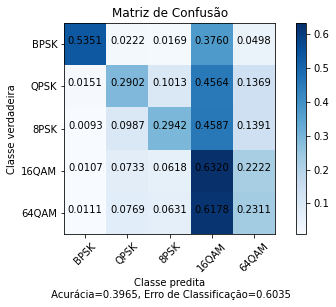

In [ ]:
# Definição da função para plotar a CM
def plot_confusion_matrix(cm, target_names, title='Confusion matrix'):
  """"
  Baseada na biblioteca ScikitLearn
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

  """

  accuracy = np.trace(cm) / float(np.sum(cm)) # acuracia
  misclass = 1 - accuracy                     # erro de classificacao

  cmap = plt.get_cmap('Blues') #Cor de fundo, no caso niveis azul

  # gera a figura da matriz de confusao
  plt.figure()
  im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  # gera as legendas com um angulo de 45 graus
  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  # gera a escrita no interior dos quadrados
  for i in range(0, cm.shape[0]):
    for j in range(0, cm.shape[1]):
      plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment="center", color="black")

  plt.tight_layout()
  plt.ylabel('Classe verdadeira')
  plt.xlabel('Classe predita\n Acurácia={:0.4f}, Erro de Classificação={:0.4f}'.format(accuracy, misclass))
  #plt.show()
# fim plot_confusion_matrix

# Matriz de Confusao de todo o dataset
X = test_data   # X sao os dados          
Y = test_lbls   # Y sao as labels
#y_pred = model.predict_classes(X_test, batch_size=batch_size)
y_pred = np.argmax(model.predict(X, batch_size=128), axis=1) #np.argmax pois model.predict_class vai ser removido do TF

classes =  ['BPSK', 'QPSK', '8PSK', '16QAM','64QAM']           # classes ou target_names
confmatrix = np.zeros([len(classes),len(classes)])      # Matriz de confusao
confmatrix_norm = np.zeros([len(classes),len(classes)]) # Matriz de confusao normalizada
for i in range(0,y_pred.shape[0]):
  j = list(Y[i,:]).index(1)
  k = y_pred[i]
  confmatrix[j,k] = confmatrix[j,k] + 1

for i in range(0,len(classes)):
  confmatrix_norm[i,:] = confmatrix[i,:] / np.sum(confmatrix[i,:])

plot_confusion_matrix(confmatrix_norm,classes,"Matriz de Confusão")

plt.savefig(f"/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/{nTx}x{nRx}/allsnrs.png", dpi=120, bbox_inches="tight")

plt.show()

<Figure size 432x288 with 0 Axes>

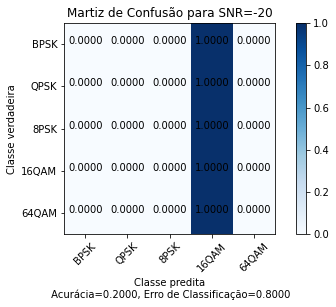

<Figure size 432x288 with 0 Axes>

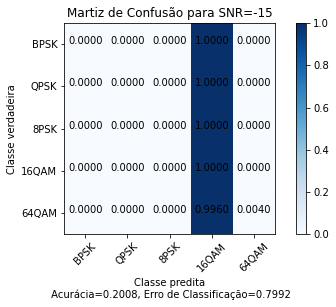

<Figure size 432x288 with 0 Axes>

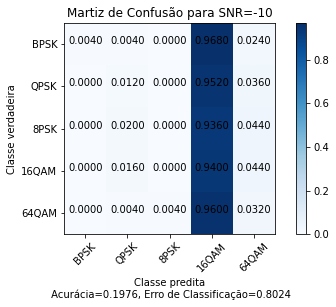

<Figure size 432x288 with 0 Axes>

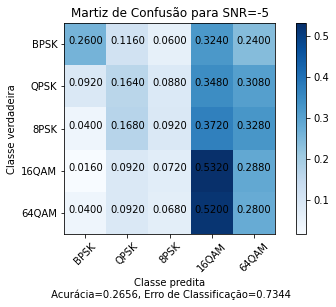

<Figure size 432x288 with 0 Axes>

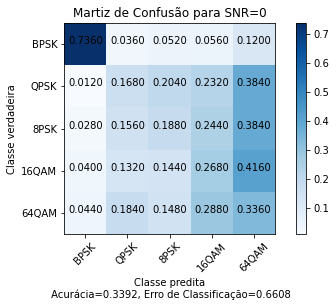

<Figure size 432x288 with 0 Axes>

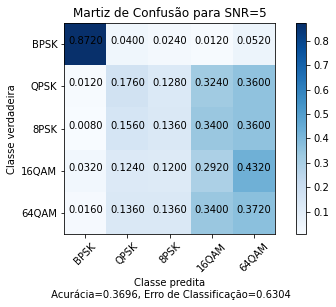

<Figure size 432x288 with 0 Axes>

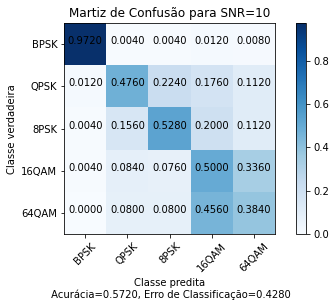

<Figure size 432x288 with 0 Axes>

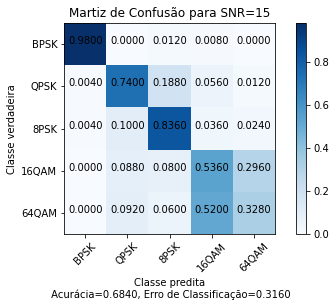

<Figure size 432x288 with 0 Axes>

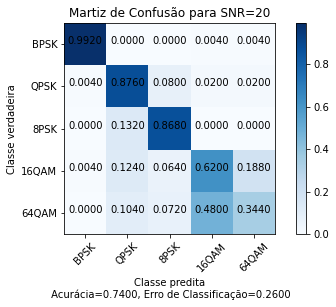

In [ ]:
SNRs = list(range(-20,25,5))
acc = {}
idx = np.arange(0,len(test_data))
for snr in SNRs:
    test_SNRs = list(map(lambda x: test_snrs[x], idx))
    test_X_i = X[(np.where(np.array(test_SNRs)==snr))]
    test_Y_i = Y[(np.where(np.array(test_SNRs)==snr))]    
 

    test_Y_i_hat = model.predict(test_X_i)
    classes = ['BPSK', 'QPSK', '8PSK', '16QAM', '64QAM']
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    plt.figure()
    plot_confusion_matrix(confnorm, classes, title="Martiz de Confusão para SNR=%d"%(snr))
    plt.savefig(f"/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/{nTx}x{nRx}/{snr}.png", dpi=120, bbox_inches="tight")
    
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc[snr] = 1.0*cor/(cor+ncor)

In [ ]:
acc

{-20: 0.2,
 -15: 0.2008,
 -10: 0.1976,
 -5: 0.2656,
 0: 0.3392,
 5: 0.3696,
 10: 0.572,
 15: 0.684,
 20: 0.74}

In [ ]:
# txt = open(f"/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/{nTx}x{nRx}/acc_{nTx}_{nRx}.txt","w")
# txt.write(str(acc))
# txt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

f = open('/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/1x2/acc_1_2.txt', 'r')
acc_1x2 = f.read()
f.close()

f = open('/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/1x4/acc_1_4.txt', 'r')
acc_1x4 = f.read()
f.close()

f = open('/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/2x2/acc_2_2.txt', 'r')
acc_2x2 = f.read()
f.close()

f = open('/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/2x4/acc_2_4.txt', 'r')
acc_2x4 = f.read()
f.close()

f = open('/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/4x4/acc_4_4.txt', 'r')
acc_4x4 = f.read()
f.close()

In [ ]:
sys_1x2 = eval(acc_1x2)
sys_1x4 = eval(acc_1x4)
sys_2x2 = eval(acc_2x2)
sys_2x4 = eval(acc_2x4)
sys_4x4 = eval(acc_4x4)

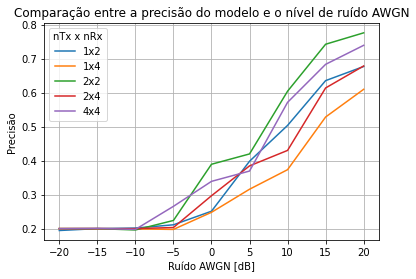

In [ ]:
plt.plot(list(sys_1x2.keys()),list(sys_1x2.values()), label='1x2')
plt.plot(list(sys_1x4.keys()),list(sys_1x4.values()), label='1x4')
plt.plot(list(sys_2x2.keys()),list(sys_2x2.values()), label='2x2')
plt.plot(list(sys_2x4.keys()),list(sys_2x4.values()), label='2x4')
plt.plot(list(sys_4x4.keys()),list(sys_4x4.values()), label='4x4')

plt.title('Comparação entre a precisão do modelo e o nível de ruído AWGN')
plt.ylabel('Precisão')
plt.xlabel('Ruído AWGN [dB]')
plt.grid()
plt.legend(title='nTx x nRx')

plt.savefig(f"/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO_Canal_Real/graph.png", dpi=120,  bbox_inches = "tight")

plt.show()